In [1]:
import gymnasium as gym

import numpy as np 
import matplotlib.pyplot as plt

In [2]:
env = gym.make("Blackjack-v1", natural = True , sab = False )

In [3]:
env.action_space


Discrete(2)

In [4]:
env.reset()
env.step(1)

((30, 9, 0), -1.0, True, False, {})

In [5]:
env.step(0)

((30, 9, 0), -1.0, True, False, {})

In [6]:
print("ACTION SPACE:\n",env.action_space, ": HIT or STICK\n")
print("OBSERVATION SPACE:\n",env.observation_space, ": user_sum, dealer_card, if_usable_ace_of_user")

ACTION SPACE:
 Discrete(2) : HIT or STICK

OBSERVATION SPACE:
 Tuple(Discrete(32), Discrete(11), Discrete(2)) : user_sum, dealer_card, if_usable_ace_of_user


## 2.1 Naı̈ve Policy
Implement an agent that carries out the following deterministic policy:

• The agent will stick if it gets a score of 20 or 21.

• Otherwise, it will hit.

Questions:
1. Using this agent, simulate 100,000 games and calculate the agent’s return
(total accumulated reward).
2. Additionally, calculate the % of wins, natural wins, losses and draws.
3. Comment on the results.

In [7]:
class NaiveAgent():
    def __init__(self,env):
        self.env = env
        
        
    def apply_policy(self,state):
        
        if state[0] >= 20:
            action = 0
        else:
            action = 1
            
        return action
        

In [8]:
num_plays = 100000
naive_agent = NaiveAgent(env)
total_reward = 0 
wins = 0
natural_wins = 0
draws = 0 
loses = 0

terminated = False
truncated = False

for ply in range(num_plays):
    
    env.reset()
    action = 1 
    
    while not terminated or truncated:
        new_state, reward, terminated, truncated,_ = env.step(action)
        
        total_reward += reward
        action = naive_agent.apply_policy(new_state)
        
        if reward == 1:
            wins += 1
        elif reward == 1.5:
            natural_wins += 1
        elif reward == -1:
            loses += 1
        elif reward == 0 and (terminated or truncated):
            draws += 1 
    terminated = False
    truncated = False

print("total_reward:", total_reward)
print("num_wins:", (wins/num_plays)*100,"%")
print("num_natural_wins:",(natural_wins/num_plays)*100,"%")
print("num loses:", (loses/num_plays)*100,"%")
print("num_draws:", (draws/num_plays)*100,"%")
print("total_played:", wins+loses+natural_wins + draws)
    
    
    

total_reward: -53936.0
num_wins: 21.046 %
num_natural_wins: 0.0 %
num loses: 74.982 %
num_draws: 3.972 %
total_played: 100000


### Comment of the results

## 2.2 Monte Carlo method
The objective of this section is to estimate the optimal policy using Monte Carlo
methods, specifically we will study algorithm “Control using MC methods with
initial explorations”.
Questions:

1. Implement Algorithm 1 using the following parameters:

• Number of episodes = 5,000,000

• Discount factor = 1

2. Implement a function that prints on the screen the optimal policy found for
each state (similar to figure 2).
3. Using the agent obtained through the Monte Carlo method, simulate 100,000
games and calculate the agent’s return (total accumulated reward).
4. Additionally, calculate the % of wins, natural wins, losses and draws.
5. Compare the optimal policy found by our agent to the optimal policy (see
figure 2).
6. Comment on the results.

In [9]:
import collections

In [10]:
class MC_Agent():
    def __init__(self,env):
        self.env = env
        self.Returns = collections.defaultdict(list)
        self.possible_user_sum = self.env.observation_space[0].n
        self.possible_dealer_sum = self.env.observation_space[1].n
        self.usable_ace = self.env.observation_space[2].n
        self.possible_actions = self.env.action_space.n
        self.Q = np.zeros((self.possible_user_sum, self.possible_dealer_sum, self.usable_ace, self.possible_actions))
        self.policy = np.ones((self.possible_user_sum, self.possible_dealer_sum, self.usable_ace, self.possible_actions))/2
        
    
    def update_Returns(self,state, action,G):
        
        self.Returns[(state,action)].append(G)
        
    def update_Q(self,state, action):
        self.Q[state[0],state[1],state[2], action] = np.mean(self.Returns[(state,action)])
        
    def epsilon_greedy_policy(self,state,epsilon):
        '''total_probs = np.ones((self.possible_user_sum, self.possible_dealer_sum, self.usable_ace, self.possible_actions))/2
        for pu in range(self.possible_user_sum):
            for pd in range(self.possible_dealer_sum):
                for a in range(self.usable_ace):'''
        probs = (np.ones(self.possible_actions) * epsilon) / self.possible_actions
        best_action = np.argmax(self.Q[state[0]][state[1]][state[2]])
        probs[best_action] += 1.0 - epsilon
        #total_probs[pu][pd][a] = probs
        self.policy[state[0],state[1],state[2]] = probs
                    
        
        

In [11]:
def generate_episode(env,agent):
    obs,_ = env.reset()
    action =  np.random.choice(range(len(agent.policy[obs[0],obs[1],obs[2]])), p = agent.policy[obs[0],obs[1],obs[2]])
    EPS = []
    total_reward = 0
    terminated = False
    truncated = False
    while not terminated or truncated:
        
        new_state, reward, terminated, truncated,_ = env.step(action)
        
        EPS.append((obs,action,reward))
        total_reward += reward
        #print(agent.policy[new_state[0],new_state[1],new_state[2]])
        action = np.random.choice(range(len(agent.policy[new_state[0],new_state[1],new_state[2]])), p = agent.policy[new_state[0],new_state[1],new_state[2]])
        obs = new_state
    return EPS
    
    
    

In [12]:
env.reset()


((15, 8, 0), {})

In [13]:
num_episodes = 5000000
discount_factor = 1 
epsilon = 0.1
epsilon_decay = 0.99

Define the general loop for the model

In [15]:
mc_agent = MC_Agent(env)
for i in range(num_episodes):
    
    EPS = generate_episode(env,mc_agent)
    G = 0 
    seen_states = []
    for eps in reversed(EPS):
        G = (discount_factor*G) + eps[2]
        if (eps[0], eps[1]) not in seen_states:
            seen_states.append((eps[0], eps[1]))
            mc_agent.update_Returns(eps[0],eps[1],G)
            mc_agent.update_Q(eps[0],eps[1])
            mc_agent.epsilon_greedy_policy(eps[0],epsilon)
    if i% 1000 == 0:
        pass
        #epsilon = epsilon *epsilon_decay 
    if i% 100000 == 0:
        print(i)
        #print(mc_agent.policy)
        
        
    

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000


In [21]:
def run_episode(env,agent):
    num_plays = 100000

    total_reward = 0 
    wins = 0
    natural_wins = 0
    draws = 0 
    loses = 0
    

    terminated = False
    truncated = False

    for ply in range(num_plays):

        state,_ = env.reset()
        action = np.argmax(agent.policy[state[0],state[1],state[2]]) 

        while not terminated or truncated:
            new_state, reward, terminated, truncated,_ = env.step(action)

            total_reward += reward
            action = np.argmax(agent.Q[new_state[0],new_state[1],new_state[2]])

        if reward == 1:
            wins += 1
        elif reward == 1.5:
            natural_wins += 1
        elif reward == -1:
            loses += 1
        elif reward == 0 and (terminated or truncated):
            draws += 1 
        
                
        terminated = False
        truncated = False

    print("total_reward:", total_reward)
    print("num_wins:", (wins/num_plays)*100,"%")
    print("num_natural_wins:",(natural_wins/num_plays)*100,"%")
    print("num loses:", (loses/num_plays)*100,"%")
    print("num_draws:", (draws/num_plays)*100,"%")
    
    print("total_played:", wins+loses+natural_wins + draws)

In [30]:
from tempfile import TemporaryFile

outfile = TemporaryFile()
np.save(outfile, mc_agent.policy)
_ = outfile.seek(0) # Only needed here to simulate closing & reopening file

np.load(outfile)

array([[[[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        ...,

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]]],


       [[[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        ...,

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]]],


       [[[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        ...,

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]]],


       ...,


       [[[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        ...,



In [32]:
mc_agent.Q

array([[[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       ...,


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

    

In [36]:
np.save('mc_policy.npy', mc_agent.policy)
loaded_array = np.load('mc_policy.npy')

In [37]:
loaded_array

array([[[[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        ...,

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]]],


       [[[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        ...,

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]]],


       [[[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        ...,

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]]],


       ...,


       [[[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5]],

        ...,



In [22]:
run_episode(env,mc_agent)

total_reward: -3623.0
num_wins: 38.23 %
num_natural_wins: 4.24 %
num loses: 48.213 %
num_draws: 9.317 %
total_played: 100000


In [23]:
pol = mc_agent.policy

In [24]:
not_use_ace= np.zeros((pol.shape[0],pol.shape[1]))
not_use_ace_deal = np.zeros((pol.shape[0],pol.shape[1]))

usable_ace= np.zeros((pol.shape[0],pol.shape[1]))
usable_ace_deal = []
pol = mc_agent.policy
for usr_sum in range(pol.shape[0]):
    for deal_sum in range(pol.shape[1]):
        for a in range(pol.shape[2]):
            if a == 0:
                #print(np.argmax(pol[usr_sum,deal_sum,a]))
                not_use_ace[usr_sum][deal_sum] = np.argmax(pol[usr_sum,deal_sum,a])
                #not_use_ace.append(np.max(pol[usr_sum,deal_sum,a]))
            elif a == 1:
                usable_ace[usr_sum][deal_sum] = np.argmax(pol[usr_sum,deal_sum,a])
                #usable_ace.append(np.max(pol[usr_sum,deal_sum,a]))
                
                


In [25]:
usable_ace

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.

In [26]:
not_use_ace

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from numpy import meshgrid

In [ ]:
not_use_ace

In [ ]:
print(np.max(mc_agent.policy).shape)

In [ ]:
mc_agent.policy[]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


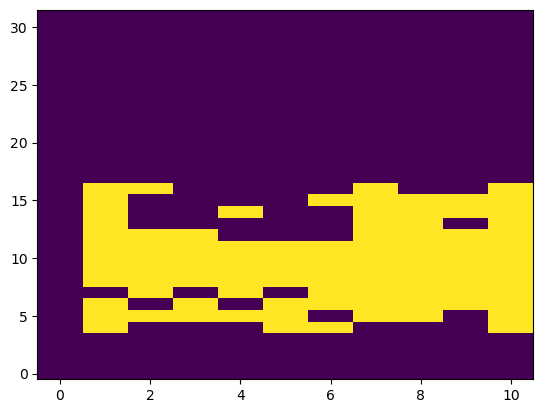

In [27]:
Z = not_use_ace
x = np.arange(pol.shape[0])  # 
print(x)
y = np.arange(pol.shape[1])  # 

fig, ax = plt.subplots()
ax.pcolormesh(y, x, Z, vmin=np.min(Z), vmax=np.max(Z), shading = "auto")

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if policy[player_hand, dealer_showing, usable_ace] != [0.5,0.5]:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

In [ ]:
plot_policy(mc_agent.policy)